In [38]:

import sys
import os
sys.path.append('/export/home/jfechtel/ordinal-bptt')
sys.path.append('/home/janik.fechtelpeter/Documents/ordinal-bptt')
sys.path.append('D:/ZI Mannheim/KI Reallabor/ordinal-bptt')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import eval_reallabor_utils
import reallabor_metrics
from data_utils import join_ordinal_bptt_path, train_test_split_path

eva_dirs = [ 
    join_ordinal_bptt_path('results/v3_MRT2_every_day/00_summary_7stepsahead_prewarming'),
    join_ordinal_bptt_path('results/v3_MRT3_every_day/00_summary_7stepsahead_prewarming'),
]
eval_files = [os.path.join(eval_dir, 'evaluation.csv') for eval_dir in eva_dirs]

combined_eval_file = eval_reallabor_utils.combine_evaluation_files(eval_files, save_path=None, specifier_name='mrt', specifier_values=[2, 3])

In [43]:
name = None
file_formats = ['png']
hyperparameters = ['prewarm_steps']
curves = ['mrt']
metrics = ['mae']
include_hyper = {}
exclude_hyper = {}#, 'Version':'PLRNN (Val Error)'}

prediction_outlier_threshold = 14
legend_bbox = (1, 0.5)
extend_ylim = True

fig_kwargs = {'figsize': (4, 2.5)}
ax_kwargs = {'linestyle':'--'}


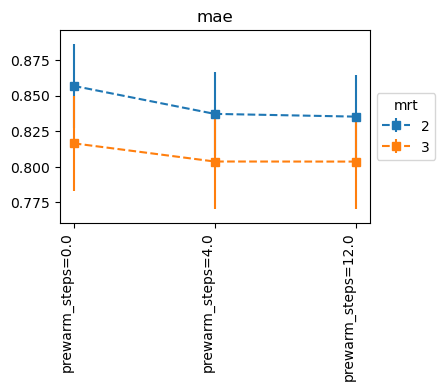

In [44]:

from decimal import Decimal
from typing import Iterable

def prepare_xticklabels(index):
    new_labels = []
    for l in index:
        if len(hyperparameters) > 1:
            nl = '\n'.join([f'{h}={x}' for h, x in zip(hyperparameters, l)])
        else:
            nl = f'{hyperparameters[0]}={l}'
        new_labels.append(nl)
    return new_labels

### Calculations ###

results_to_plot = eval_reallabor_utils.include_exclude_hypers(combined_eval_file, include_hyper, exclude_hyper).copy() 
metric_calculator = reallabor_metrics.MetricsManager(results_to_plot, hyperparameters + curves)

for m in metrics:

    this_metric_values = metric_calculator.get_metric(m)(func='mean')
    this_metric_errors = metric_calculator.get_metric(m)(func='sem')

    m_unstacked = this_metric_values.unstack(curves)
    m_unstacked.index = m_unstacked.index.astype(str)
    e_unstacked = this_metric_errors.unstack(curves)
    e_unstacked.index = e_unstacked.index.astype(str)
    
    fig, ax = plt.subplots(1, 1, **fig_kwargs)
    use_ax_kwargs = {'linestyle':'', 'marker':'s'}
    use_ax_kwargs.update(ax_kwargs)
    ax = m_unstacked.plot(ax=ax, yerr=e_unstacked, legend=True, title=m, **use_ax_kwargs)
    xticks = ax.get_xticks()
    if len(m_unstacked)>1:
        xticklabels = prepare_xticklabels(m_unstacked.index)
        ax.set_xticks(range(len(m_unstacked.index)))
        ax.set_xticklabels(xticklabels, rotation=90, ha='right')
    ax.set(xlabel=None)
    if legend_bbox is not None:
        hdls, lbls = ax.get_legend_handles_labels()
        ax.legend(hdls, lbls, bbox_to_anchor=legend_bbox, loc='center left', title=ax.get_legend().get_title().get_text())
    if extend_ylim:
        ylim = np.array(ax.get_ylim())
        ax.set_ylim(ylim + np.hstack([np.diff(-ylim)*0.03, np.diff(ylim)*0.03]))

    if name is not None:
        for ff in file_formats:
            fig.savefig(os.path.join(eval_dir, m+'_'+name+'.'+ff))

if name is not None:
    shutil.copyfile(join_ordinal_bptt_path('eval_reallabor/summary_gridsearch_plot.ipynb'),
                    os.path.join(eval_dir, name+'.ipynb'))